# Lyft: Usage Patterns, Pricing, and Google Maps Accuracy

This analysis was inspired by a 2013 [blog post](http://www.georgexing.com/200-lyft-rides-usage-patterns-and-pricing/) by [George Xing](https://twitter.com/g_xing). I've borrowed a lot of his [original code](https://github.com/george-xing/data-playground/) and methodology here.

__What does this script do?__
* Fetches and parses Lyft email receipts from your Gmail account 
* Fetches additional trip information via Google Maps API

__The resulting dataset can then be used to...__
* Generate usage pattern insights (e.g. ride frequency by day of week)
* Check the accuracy of Google Maps' distance and duration estimates for your trips
* Predict prices

__Contact:__ [Dan Kras](mailto:dan.kras@gmail.com)

Also Interesting: [pistats.io](https://pistats.io/)

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
from googlemaps import Client as GoogleMaps
import statsmodels.formula.api as sm
import getpass
import imaplib, email
import re
from datetime import datetime
from time import mktime, strptime, struct_time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##Classes and Helper Functions

In [2]:
class Receipt:
    ''' 
        Parses email receipt strings 
    '''
    
    def __init__(self, message):
        for part in message.walk():
            if part.get_content_type() == 'text/plain':
                self.year = email.utils.parsedate_tz(message['Date'])[0]
                self.email_text = part.get_payload()

    def sanitized_text(self):
        dirty_strings = ['=20', '=0A', '*']
        temp_string = self.email_text
        for s in dirty_strings:
            temp_string = temp_string.replace(s, ' ')

        return ' '.join(temp_string.replace('=\r\n', '').split())

    def check_special_addresses(self, s):     
        if s.find('Airport Access Rd, CA') != -1: # this address incorrectly maps to Oakland Airport
            return 'San Francisco International Airport'
        elif s.find('I-94, Chicago, IL 60622,') != -1: # clybourn metra stop in chicago 
            return '1658 W Cortland St, Chicago, IL 60622'            
        else:
            return s.replace('Unnamed Road,', '').replace('International Terminal Departures', '') # google maps cannot parse this address correctly

    def get_start_location(self):
        raw_start_loc = re.search('P\s?i\s?c\s?k\s?u\s?p(.*):(.*)D\s?r\s?o\s?p\s?o\s?f\s?f', self.sanitized_text())
        try:
            return self.check_special_addresses(raw_start_loc.group(2).strip())
        except ValueError:
            return 'Bad start address string!'

    def get_end_location(self):
        raw_end_loc = re.search('D\s?r\s?o\s?p\s?o\s?f\s?f(.*?):(.*?)(USA|Lyft ride|Ride|Donation given|Donation:)', self.sanitized_text())
        try:
            return self.check_special_addresses(raw_end_loc.group(2).strip())
        except ValueError:
            return 'Bad end address string!'
    
    def is_split_fare(self):
        return 'Split Fee:' in self.sanitized_text()
        
    def is_prime_time(self):
        return "Prime Time" in self.sanitized_text()
    
    def get_tip(self):
        raw_tip = re.search('Tip: \$((?:\d*\.)?\d+)', self.sanitized_text())
        return (float(raw_tip.group(1).strip())) if raw_tip is not None else 0   
    
    def get_distance(self):
        raw_distance = re.search('Ride ((?:\d*\.)?\d+) mi', self.sanitized_text())
        return float(raw_distance.group(1).strip()) if raw_distance is not None else np.nan
    
    def get_duration(self):
        raw_duration = re.search('mi & ((?:\d*\.)?\d+) min', self.sanitized_text())
        return float(raw_duration.group(1).strip()) if raw_duration is not None else np.nan
            
    def get_bonus(self):
        raw_bonus = re.search('Lyft Credits applied: - \$(.*) Card', self.sanitized_text())
        return int(float(raw_bonus.group(1))) if raw_bonus is not None else 0

    def get_time(self):
        '''
            Example 1: "Ride completed on September 22, 2012 at 7:02 PM Your Driver"
            Example 2: "Ride completed on November 25 at 10:07 AM Your Driver"
            Example 3: "Ride completed on December 13, 2012 Your Driver"
        '''

        ## special hardcoded cases where timestamps are missing
        if self.sanitized_text().find('Receipt #1013515411') != -1:
            return datetime(2012, 12, 13, 10, 0, 0)
        elif self.sanitized_text().find('Receipt #1381856898') != -1:
            return datetime(2012, 12, 15, 10, 0, 0)
        elif self.sanitized_text().find('Receipt #1738191832') != -1:
            return datetime(2012, 12, 16, 1, 0, 0)
        elif self.sanitized_text().find('Receipt #1528835456') != -1:
            return datetime(2012, 12, 16, 13, 0, 0)

        ## otherwise normal processing
        raw_date = re.search("Ride completed on (.*) Your Driver", self.sanitized_text())
        if raw_date is not None:
            raw_date_final = raw_date.group(1)
            temp = " ".join(raw_date_final.replace("at"," ").strip().split())

            ## append year if not already there
            if temp.find('2012') == -1:
                temp = str(self.year) + ' ' + temp

            ## try parsing with both formats
            try:
                t_struct1 = strptime(temp, '%Y %B %d %I:%M %p')
            except ValueError:
                t_struct1 = 'bad date string!'
            try:
                t_struct2 = strptime(temp, '%B %d, %Y %I:%M %p')
            except ValueError:
                t_struct2 = 'bad date string!'

            ## return the appropriate struct
            t_struct = t_struct1 if type(t_struct1) is struct_time else t_struct2

        return datetime.fromtimestamp(mktime(t_struct))

    def get_price(self):
        '''
            Example 1: "Donation:"
            Example 2: "Donation given to Tory:"
            Example 3: "Lyft ride charges:"
            Example 4: "Total charged to Visa ****:"
        '''

        case1 = re.search('Donation( given)? to ([\.\s\w]+): \$(\d+\.\d+)( Lyft Credits applied:\s\-\s\$\d+\.\d+)? Card ending with', self.sanitized_text())
        case2 = re.search('Lyft ride charges: \$(.*)(Card ending with|Lyft Credits)', self.sanitized_text())
        case3 = re.search('Donation: \$(.*) Total', self.sanitized_text())
        case4 = re.search('Total charged to ([^\s]+) [0-9]+: \$([^\s]+)', self.sanitized_text())        

        if case1 is not None:
            return int(float(case1.group(3)))
        elif case2 is not None:
            return int(float(case2.group(1)))
        elif case3 is not None:
            return int(float(case3.group(1)))
        elif case4 is not None:
            return float(case4.group(2))

    def to_ride(self):
        return Ride(self.get_start_location(), 
                    self.get_end_location(), 
                    self.get_time(), 
                    self.get_price(), 
                    self.get_bonus(),
                    self.sanitized_text(), 
                    self.is_split_fare(), 
                    self.is_prime_time(), 
                    self.get_distance(), 
                    self.get_duration(),
                    self.get_tip())

In [3]:
class Ride:
    '''
        Encapsulates ride information. 
    '''
    def __init__(self, loc_start, loc_end, time, price, bonus, receipt_text, is_split, is_prime_time, receipt_distance, receipt_duration, tip):
        self.loc_start = loc_start      
        self.loc_end = loc_end
        self.coordinates_start = None
        self.coordinates_end = None
        self.time = time
        self.price = price
        self.bonus = bonus
        self.google_payload_dict = None
        self.distance_meters = None
        self.total_duration_sec = None
        self.receipt_text = receipt_text
        self.is_split = is_split
        self.is_prime_time = is_prime_time
        self.receipt_distance = receipt_distance
        self.receipt_duration = receipt_duration
        self.tip = tip

    def to_string(self):
        s = 'Start: %(loc_start)s\nEnd: %(loc_end)s\nTime: %(time)s\nPrice: %(price)f\nBonus: %(bonus)d\nDistance (m): %(distance)d\nDuration (sec): %(duration)d' % \
        {"loc_start": self.loc_start, "loc_end": self.loc_end, "time": self.time, "price": self.price, "bonus": self.bonus, "distance": self.distance_meters, "duration": self.total_duration_sec}
        return s

    def set_gmaps_distance(self, GMAPS):
        if not self.loc_start or not self.loc_end:
            self.distance = 0
        else:
            self.set_gmaps_data(GMAPS.directions(self.loc_start, self.loc_end))
        return self

    def set_gmaps_data(self, payload):
        self.google_payload_dict = payload[0]
        legs_dict = self.google_payload_dict['legs'][0]
        self.distance_meters = legs_dict['distance']['value']
        self.loc_start = legs_dict['start_address']
        self.loc_end = legs_dict['end_address']
        self.coordinates_start = legs_dict['start_location']
        self.coordinates_end = legs_dict['end_location']
        self.total_duration_sec = legs_dict['duration']['value']              
        return self

In [4]:
def connect_to_gmail(username, password):
    mail = imaplib.IMAP4_SSL('imap.gmail.com', '993')
    mail.login(username, password)
    return mail

In [5]:
def fetch_receipts(mail, directory='[Gmail]/All Mail', search_type='FROM', search_text='no-reply@lyftmail.com'):
    '''
        Retrieves email receipts from 'no-reply@lyftmail.com' (or configured search_text), returns list
        of Receipt objects.
    '''
    mail.select(directory)
    search_command = '(' + str(search_type) + ' "' + str(search_text) +  '")'
    response, message_ids = mail.search(None, search_command)
    
    receipts = []
    
    for msg_id in message_ids[0].split():
        typ, msg_data = mail.fetch(msg_id, '(RFC822)')
        msg = email.message_from_string(msg_data[0][1])
        receipts.append(Receipt(msg))
    
    return receipts

In [6]:
def to_day_of_week(row):
    '''Given row of dataframe, returns day of week based on timestamp field'''
    days = {0 : 'Mon', 1 : 'Tue', 2 : 'Wed', 3 : 'Thurs', 4 : 'Fri', 5 : 'Sat', 6 : 'Sun'}
    return days[row['timestamp'].dayofweek]

def to_hour(row):
    '''Given row of dataframe, returns hour of day based on timestamp field'''
    return row['timestamp'].hour

def to_miles(row):
    '''given row of dataframe, converts distance in meters to distance in miles'''
    METERS_PER_MILE = 1609.34
    return row['gmaps_distance_m'] * 1.0 / METERS_PER_MILE

def to_minutes(row):
    '''given row of dataframe, converts duration in seconds to duration in minutes'''
    SECONDS_PER_MINUTE = 60.0
    return row['gmaps_duration_sec'] * 1.0 / SECONDS_PER_MINUTE

In [7]:
def predicted_price(miles, minutes, tip):
    '''
        Given a distance (in miles), a duration (in minutes), and a tip (in dollars) of a Lyft trip, 
        returns the predicted cost as per current (2/2/16) prices in Chicago
        https://www.lyft.com/cities/chicago
    '''
    BASE = 1.71
    TRUST_AND_SERVICE_FEE = 1.60
    CITY_AND_ACCESSIBILITY_FEE = 0.50
    PER_MILE = 0.90
    PER_MIN = 0.22
    
    COST_MINIMUM = 3.00 #interestingly, lyft's cost minimum is less than their fixed costs...
    #i.e. it will never be applied.
    
    fixed = BASE + TRUST_AND_SERVICE_FEE + CITY_AND_ACCESSIBILITY_FEE
    variable = PER_MILE * miles + PER_MIN * minutes
    
    cost = fixed + variable
    
    if cost < COST_MINIMUM:
        return COST_MINIMUM + tip
    else:
        return cost + tip

#Analysis

In [8]:
# connect to gmail server
print 'connecting to gmail server...'
username = raw_input("Gmail username: ")
pw = getpass.getpass()
mail = connect_to_gmail(username, pw)
print 'done.'

# fetch the relevant receipts
print 'fetching lyft receipts...'
receipts = fetch_receipts(mail)
print 'done.'

# parse ride data, grabbing distances from google maps
print 'grabbing distances...'
GOOGLE_API_KEY = open("google_maps_key.txt", "r").read()
GMAPS = GoogleMaps(GOOGLE_API_KEY)
rides = []

for receipt in receipts:
    ride = receipt.to_ride().set_gmaps_distance(GMAPS)
    rides.append(ride)

print 'done.'

# generate data frame
print 'generating data...'
data = {'timestamp' : [ride.time for ride in rides], 
        'start_address' : [ride.loc_start for ride in rides], 
        'end_address' : [ride.loc_end for ride in rides], 
        'gmaps_distance_m' : [ride.distance_meters for ride in rides], 
        'receipt_distance_mi' : [ride.receipt_distance for ride in rides],
        'gmaps_duration_sec' : [ride.total_duration_sec for ride in rides], 
        'receipt_duration_min' : [ride.receipt_duration for ride in rides],
        'predicted_price' : [predicted_price(ride.receipt_distance, ride.receipt_duration, ride.tip) for ride in rides],
        'price_paid' : [ride.price for ride in rides], 
        'tip' : [ride.tip for ride in rides],
        'is_split' : [ride.is_split for ride in rides],
        'is_prime_time' : [ride.is_prime_time for ride in rides],
        'start_lat' : [ride.coordinates_start['lat'] for ride in rides], 
        'start_long' : [ride.coordinates_start['lng'] for ride in rides], 
        'end_lat' : [ride.coordinates_end['lat'] for ride in rides], 
        'end_long' : [ride.coordinates_end['lng'] for ride in rides], 
        'bonus' : [ride.bonus for ride in rides], 
        'pretty_string' : [ride.to_string() for ride in rides], 
        'ride_obj' : [ride for ride in rides] }
    
rides_df = pd.DataFrame(data)

# create some additional fields
rides_df['day_of_week'] = rides_df.apply(lambda row : to_day_of_week(row), axis=1)
rides_df['hour'] = rides_df.apply(lambda row : to_hour(row), axis=1)
rides_df['gmaps_distance_mi'] = rides_df.apply(lambda row : to_miles(row), axis=1)
rides_df['gmaps_duration_min'] = rides_df.apply(lambda row : to_minutes(row), axis=1)

# more intuitive ordering of columns
rides_df = rides_df[['timestamp', 
                     'day_of_week',
                     'hour',
                     'start_address', 
                     'end_address', 
                     'receipt_distance_mi',
                     'gmaps_distance_mi',
                     'receipt_duration_min', 
                     'gmaps_duration_min',
                     'predicted_price',
                     'price_paid', 
                     'tip', 
                     'is_split',
                     'is_prime_time',
                     'start_lat', 
                     'start_long', 
                     'end_lat', 
                     'end_long', 
                     'bonus', 
                     'pretty_string', 
                     'ride_obj']]

print 'done.'

connecting to gmail server...
Gmail username: dan.kras
········
done.
fetching lyft receipts...
done.
grabbing distances...
done.
generating data...
done.


In [9]:
# sample of data
pd.set_option('display.max_columns', None)
rides_df.head()

,timestamp,day_of_week,hour,start_address,end_address,receipt_distance_mi,gmaps_distance_mi,receipt_duration_min,gmaps_duration_min,predicted_price,price_paid,tip,is_split,is_prime_time,start_lat,start_long,end_lat,end_long,bonus,pretty_string,ride_obj
0,2015-01-17 00:59:00,Sat,0,"1644 N Leavitt St, Chicago, IL 60647, USA","149 W Hubbard St, Chicago, IL 60654, USA",3.7,3.718916,15,13.300000,11.44,3.98,1,True,False,41.911683,-87.682375,41.890010,-87.632443,0,"Start: 1644 N Leavitt St, Chicago, IL 60647, U...",<__main__.Ride instance at 0x1099ec050>
1,2015-04-04 22:54:00,Sat,22,"1644 N Leavitt St, Chicago, IL 60647, USA","1298 W Diversey Pkwy, Chicago, IL 60614, USA",2.8,2.547628,12,11.483333,10.97,6.48,2,True,True,41.911683,-87.682375,41.932509,-87.661127,0,"Start: 1644 N Leavitt St, Chicago, IL 60647, U...",<__main__.Ride instance at 0x1099d78c0>
2,2015-04-05 02:07:00,Sun,2,"807 W Belmont Ave, Chicago, IL 60657, USA","1628 N Honore St, Chicago, IL 60622, USA",4.2,3.245430,17,15.933333,12.33,6.27,1,True,False,41.939963,-87.649638,41.911448,-87.673828,0,"Start: 807 W Belmont Ave, Chicago, IL 60657, U...",<__main__.Ride instance at 0x1099f8b48>
3,2015-07-19 03:18:00,Sun,3,"99 Essex St, New York, NY 10002, USA","923 Pacific St, Brooklyn, NY 11238, USA",4.3,4.181839,21,20.233333,14.30,14.28,2,True,True,40.719010,-73.987980,40.680161,-73.963859,0,"Start: 99 Essex St, New York, NY 10002, USA\nE...",<__main__.Ride instance at 0x109a04e60>
4,2015-08-01 23:57:00,Sat,23,"1279 S Michigan Ave, Chicago, IL 60605, USA","1635 N Honore St, Chicago, IL 60622, USA",6.7,5.079722,27,15.616667,20.78,27.49,5,False,True,41.866108,-87.624103,41.911598,-87.673831,0,"Start: 1279 S Michigan Ave, Chicago, IL 60605,...",<__main__.Ride instance at 0x109a04ea8>


In [10]:
# descriptive stats
rides_df.describe()

,hour,receipt_distance_mi,gmaps_distance_mi,receipt_duration_min,gmaps_duration_min,predicted_price,price_paid,tip,is_split,is_prime_time,start_lat,start_long,end_lat,end_long,bonus
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32,32,32.000000,32.000000,32.000000,32.000000,32
mean,10.968750,3.098750,3.093329,14.062500,10.820312,10.442625,10.630000,0.750000,0.125,0.21875,41.870519,-87.239737,41.859148,-87.220881,0
std,6.291235,0.907971,0.726519,4.832267,2.861322,2.459751,4.133492,1.016001,0.3360108,0.4200134,0.210477,2.418219,0.215567,2.419183,0
min,0.000000,0.600000,0.539973,2.000000,2.583333,4.790000,3.980000,0.000000,False,False,40.719010,-87.682375,40.680161,-87.682375,0
25%,9.000000,2.822500,3.043328,11.750000,9.750000,9.394000,9.297500,0.000000,0,0,41.910556,-87.673832,41.889927,-87.663373,0
50%,9.000000,3.005000,3.132961,14.000000,10.216667,10.010000,9.770000,1.000000,0,0,41.911382,-87.673827,41.889927,-87.638622,0
75%,9.750000,3.200000,3.184069,16.250000,10.645833,10.987500,11.205000,1.000000,0,0,41.911660,-87.673133,41.911398,-87.638262,0
max,23.000000,6.700000,5.079722,27.000000,20.233333,20.780000,27.490000,5.000000,True,True,41.939963,-73.987980,41.932509,-73.963859,0


Fri      7
Mon      6
Tue      5
Sat      4
Wed      4
Sun      3
Thurs    3
dtype: int64


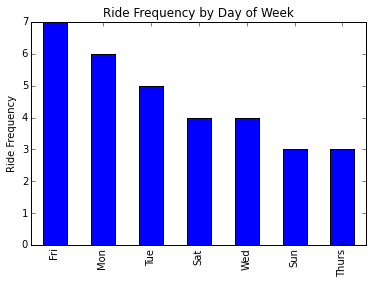

In [11]:
# frequency by day of week
print rides_df.day_of_week.value_counts()
dow_frequency_plt = rides_df.day_of_week.value_counts().plot(kind='bar', title = 'Ride Frequency by Day of Week')
dow_frequency_plt.set_ylabel('Ride Frequency')

9     19
23     2
22     2
21     2
3      2
20     1
12     1
8      1
2      1
0      1
dtype: int64


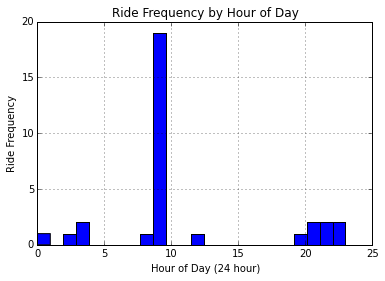

In [12]:
# frequency by hour
print rides_df.hour.value_counts()
hour_histogram = rides_df.hour.hist(bins=24)
hour_histogram.set_xlabel('Hour of Day (24 hour)')
hour_histogram.set_ylabel('Ride Frequency')
hour_histogram.set_title('Ride Frequency by Hour of Day')

__Accuracy of Google Maps__
* Difference between actual ride distance in miles (as per receipt) vs. Google Maps estimated ride distance in miles
* Negative = Google underestimated (actual distance > estimated distance)
* Positive = Google overestimated (actual distance < estimated distance)

In [14]:
estimated_vs_actual_df = rides_df[['gmaps_distance_mi', 'receipt_distance_mi', 'gmaps_duration_min', 'receipt_duration_min']]
estimated_vs_actual_df.loc[:, 'distance_diff_mi'] = (estimated_vs_actual_df.gmaps_distance_mi - estimated_vs_actual_df.receipt_distance_mi)
estimated_vs_actual_df.loc[:, 'duration_diff_min'] = (estimated_vs_actual_df.gmaps_duration_min - estimated_vs_actual_df.receipt_duration_min)
#estimated_vs_actual_df = estimated_vs_actual_df[['distance_diff_mi', 'duration_diff_min']]
estimated_vs_actual_df.describe()

,gmaps_distance_mi,receipt_distance_mi,gmaps_duration_min,receipt_duration_min,distance_diff_mi,duration_diff_min
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,3.093329,3.098750,10.820312,14.062500,-0.005421,-3.242188
std,0.726519,0.907971,2.861322,4.832267,0.464422,4.126071
min,0.539973,0.600000,2.583333,2.000000,-1.620278,-12.183333
25%,3.043328,2.822500,9.750000,11.750000,-0.132979,-5.254167
50%,3.132961,3.005000,10.216667,14.000000,0.032278,-2.866667
75%,3.184069,3.200000,10.645833,16.250000,0.190302,-0.616667
max,5.079722,6.700000,20.233333,27.000000,1.062344,5.016667


__On average, Google Maps estimated the correct distance of the trip but tended to understimate the duration by about 3 minutes (off by ~20%).__
This difference between Google's trip duration estimate and the actual duration is statistically significant (p < 0.05)

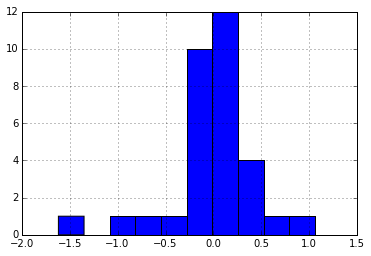

In [15]:
# On average, Google Maps estimated the correct distance of the trip ... 
estimated_vs_actual_df.distance_diff_mi.hist()

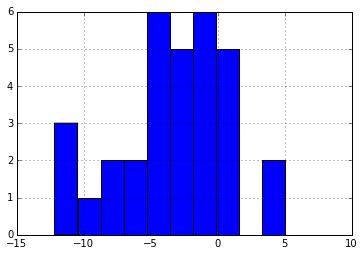

In [16]:
# ... but tended to understimate the duration by about 3 minutes. 
estimated_vs_actual_df.duration_diff_min.hist()

In [17]:
# Was this difference between Google's trip duration estimate and the actual duration statistically significant?
ttest_ind(estimated_vs_actual_df.gmaps_duration_min, estimated_vs_actual_df.receipt_duration_min)

# --> Yes: p < 0.05

(-3.265850101905873, 0.0017799666954499845)

In [18]:
# look at non-split, non-prime-time rides
single_payer_non_prime_df = rides_df[(rides_df['is_split'] == False) & (rides_df['is_prime_time'] == False)]

In [20]:
# generate dimension representing the price paid before tip
single_payer_non_prime_df.loc[:, 'price_paid_minus_tip'] = (single_payer_non_prime_df.price_paid - single_payer_non_prime_df.tip)

__What is Lyft's pricing structure (base fee, price per mile, price per minute) based on my data?__
* Used OLS regression to predict price_paid based on distance and duration
* Result: \$3.79 base, \$0.88 per mile, \$0.22 per minute
* vs. Actual: \$3.81 base, \$0.90 per mile, \$0.22 per minute [(as per 2/2/16 prices in Chicago)](https://www.lyft.com/cities/chicago)
* Why does this not match up precisely? --> Pricing structure has varied over time. Price is also location dependent, and I've taken several rides in other cities (e.g. St. Louis, NYC), where the pricing structure is not the same.


In [21]:
ols_result = sm.ols(formula='price_paid_minus_tip ~ receipt_distance_mi + receipt_duration_min', data=single_payer_non_prime_df).fit()
print ols_result.params

Intercept               3.794361
receipt_distance_mi     0.878543
receipt_duration_min    0.216429
dtype: float64


In [22]:
def scatter_regression(df, x_name, y_name, slack):
    '''
        Generate scatter plot of two-dimensional data. 
    '''
    x_max = df[x_name].max() + slack
    scatter = df[[x_name, y_name]].plot(x = x_name, y = y_name, kind = 'scatter', xlim = (0, x_max), ylim = (0))
    ols_result = sm.ols(formula=y_name + " ~ " + x_name, data=df).fit()
    print ols_result.params

    #plot regression line
    slope, intercept = ols_result.params[1], ols_result.params[0]
    N = 2 # 2 points for straight line
    points = np.linspace(x_max, 0, N)
    plt.plot(points, slope * points + intercept)

Intercept               5.851820
receipt_duration_min    0.292822
dtype: float64


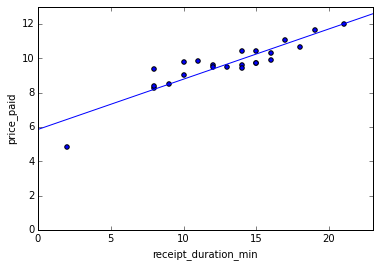

In [23]:
# price by time in minutes
scatter_regression(single_payer_non_prime_df, 'receipt_duration_min', 'price_paid', 2)

#Future Work
* Incorporate Lyft Line (carpool)
* Pull in Uber data. Compare Uber vs. Lyft